In [1]:
"""
Changes from OHE2:
-Here we do not drop features according to correlation with the target
-We also try here lambda = 1e-7
"""

'\nChanges from OHE2:\n-Here we do not drop features according to correlation with the target\n-We also try here lambda = 1e-7\n'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Data_cleaning import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

In [4]:
Y_tr = (y_train + 1) / 2

In [5]:
X_train, keep_mask = remove_nan_features(x_train, 0.2)
X_test = x_test[:, keep_mask]

In [6]:
print(X_train.shape, X_test.shape)

(328135, 143) (109379, 143)


In [7]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [8]:
print(np.sum(cat_mask), np.sum(num_mask))

99 44


In [9]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [10]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 143) (229695, 143) (229695,) (49220, 143) (49220,) (49220, 143) (49220,)


In [11]:
def impute_categorical_missing_code(X, cat_mask, missing_code=-1.0):
    """
    Replace NaNs in *categorical* columns with a special code (default -1),
    leaving numeric columns unchanged.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Full feature matrix (numeric + categorical).
    cat_mask : np.ndarray of bool, shape (n_features,)
        True for categorical columns, False for numeric ones.
    missing_code : float, default=-1.0
        Code used to represent 'Missing' category.

    Returns
    -------
    X_imputed : np.ndarray, same shape as X
        Copy of X where NaNs in categorical columns are replaced by `missing_code`.
    """
    Xf = np.array(X, dtype=np.float64, copy=True)
    cat_idx = np.where(cat_mask)[0]

    for j in cat_idx:
        col = Xf[:, j]
        nan_mask = np.isnan(col)
        if np.any(nan_mask):
            col[nan_mask] = missing_code
            Xf[:, j] = col

    return Xf


In [12]:
# Numerical imputation (compute medians from training)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
# Apply same medians to val/test
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)
# Categorical imputation (compute modes from training)
x_tr_imp = impute_categorical_missing_code(x_tr_imp, cat_mask)
x_va_imp = impute_categorical_missing_code(x_va_imp, cat_mask)
x_te_imp = impute_categorical_missing_code(x_te_imp, cat_mask)
x_test_imp = impute_categorical_missing_code(x_test_imp, cat_mask)

In [13]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


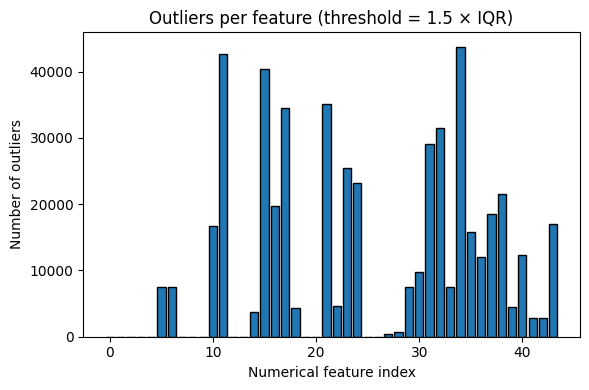

In [14]:
outlier_mask, outlier_counts = detect_outliers(x_tr_imp, num_mask, threshold=1.5, plot=True)

In [15]:
print(outlier_counts)

[    0     0     0     0     0  7523  7523     0     0     0 16765 42722
     0     0  3745 40468 19668 34545  4275     0     0 35062  4608 25522
 23171     0     0   441   754  7544  9823 29058 31441  7525 43748 15806
 12023 18456 21474  4498 12403  2772  2772 16957]


In [16]:
outlier_pctg = outlier_counts / x_tr_imp.shape[0]
print(outlier_pctg)

[0.         0.         0.         0.         0.         0.03275213
 0.03275213 0.         0.         0.         0.07298809 0.18599447
 0.         0.         0.01630423 0.17618146 0.08562659 0.15039509
 0.01861164 0.         0.         0.1526459  0.02006139 0.11111256
 0.10087725 0.         0.         0.00191994 0.00328261 0.03284355
 0.04276541 0.12650689 0.13688152 0.03276084 0.19046126 0.06881299
 0.05234332 0.08035003 0.09348919 0.01958249 0.05399769 0.01206818
 0.01206818 0.07382398]


In [17]:
drop_threshold = 0.1
new_num_mask = outlier_pctg < drop_threshold


In [18]:
#Change the mask again
keep_mask = np.ones(x_tr_imp.shape[1], dtype=bool)
num_indices = np.where(num_mask)[0]
keep_mask[num_indices] = new_num_mask

In [19]:
x_tr_filt = x_tr_imp[:, keep_mask]
x_va_filt = x_va_imp[:, keep_mask]
x_te_filt = x_te_imp[:, keep_mask]
x_test_filt = x_test_imp[:, keep_mask]
num_mask = num_mask[keep_mask]
cat_mask = cat_mask[keep_mask]

In [20]:
print(np.sum(num_mask), np.sum(cat_mask))

35 99


In [21]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_filt, cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_filt, cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_filt, cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_filt, cat_mask, categories, drop_first=True)

In [22]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 392) (49220, 392) (49220, 392) (109379, 392)


In [23]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [24]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

357 35


In [25]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [26]:
x_tr_std, means, stds = standardize_features(x_tr_enc, num_mask_enc)
x_va_std, _, _ = standardize_features(x_va_enc, num_mask_enc, means, stds)
x_te_std, _, _ = standardize_features(x_te_enc, num_mask_enc, means, stds)
x_test_std, _, _ = standardize_features(x_test_enc, num_mask_enc, means, stds)

In [27]:
corr_y = feature_target_correlation(x_tr_std, y_tr)


In [28]:

min_corr = 0.01
keep_mask_corr = np.abs(corr_y) > min_corr


In [29]:
x_tr_sel = x_tr_std[:, keep_mask_corr]
x_va_sel = x_va_std[:, keep_mask_corr]
x_te_sel = x_te_std[:, keep_mask_corr]
x_test_sel = x_test_std[:, keep_mask_corr]

In [30]:
print(x_tr_sel.shape, x_va_sel.shape, x_te_sel.shape, x_test_sel.shape)

(229695, 238) (49220, 238) (49220, 238) (109379, 238)


In [31]:
cat_mask_sel, num_mask_sel = detect_categorical_features(x_tr_sel, max_unique=10)

In [32]:
print(np.sum(cat_mask_sel))

212


In [33]:
corr_mat = correlation_matrix(x_tr_sel)


In [34]:
threshold = 0.9
to_drop = set()

for i in range(corr_mat.shape[0]):
    for j in range(i + 1, corr_mat.shape[1]):
        if abs(corr_mat[i, j]) > threshold:
            # Compare absolute correlation with y
            if abs(corr_y[i]) < abs(corr_y[j]):
                to_drop.add(i)
            else:
                to_drop.add(j)

keep_mask_inter = np.ones(x_tr_sel.shape[1], dtype=bool)
keep_mask_inter[list(to_drop)] = False



In [35]:
x_tr_final = x_tr_sel[:, keep_mask_inter]
x_va_final = x_va_sel[:, keep_mask_inter]
x_te_final = x_te_sel[:, keep_mask_inter]
x_test_final = x_test_sel[:, keep_mask_inter]

In [36]:
print("Dropped (low corr):", np.sum(~keep_mask_corr))
print("Dropped (high inter):", np.sum(~keep_mask_inter))
print("Remaining features:", x_tr_final.shape[1])


Dropped (low corr): 154
Dropped (high inter): 47
Remaining features: 191


In [37]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_final,
    y_va, x_va_final,
    pos_weights=[6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10],
    lambdas=[1e-8, 1e-4],
    thresholds=np.linspace(0.5, 0.9, 400),
    max_iter=10000,
    gamma=0.5
)



=== Run 1/18 (pos_weight=6, lambda_=1e-08) ===
New best F1 = 0.4103 (threshold = 0.50)
New best F1 = 0.4105 (threshold = 0.51)
New best F1 = 0.4111 (threshold = 0.51)
New best F1 = 0.4114 (threshold = 0.51)
New best F1 = 0.4118 (threshold = 0.51)
New best F1 = 0.4120 (threshold = 0.51)
New best F1 = 0.4122 (threshold = 0.51)
New best F1 = 0.4125 (threshold = 0.51)
New best F1 = 0.4128 (threshold = 0.52)
New best F1 = 0.4128 (threshold = 0.52)
New best F1 = 0.4134 (threshold = 0.52)
New best F1 = 0.4135 (threshold = 0.53)
New best F1 = 0.4135 (threshold = 0.53)
New best F1 = 0.4137 (threshold = 0.53)
New best F1 = 0.4139 (threshold = 0.53)
New best F1 = 0.4139 (threshold = 0.54)
New best F1 = 0.4141 (threshold = 0.54)
New best F1 = 0.4142 (threshold = 0.54)
New best F1 = 0.4145 (threshold = 0.54)
New best F1 = 0.4147 (threshold = 0.55)
New best F1 = 0.4152 (threshold = 0.55)
New best F1 = 0.4158 (threshold = 0.55)
New best F1 = 0.4158 (threshold = 0.55)
New best F1 = 0.4160 (threshold 

In [38]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [39]:
best_lambda = 0.0001
best_pos_weight = 9.0
best_neg_weight = 1.0
best_threshold = 0.7155388471177945

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.4863
Iter   100 | Loss = 0.469902 | GradNorm = 0.0113
Iter   200 | Loss = 0.466304 | GradNorm = 0.0061
Iter   300 | Loss = 0.465023 | GradNorm = 0.0040
Iter   400 | Loss = 0.464409 | GradNorm = 0.0029
Iter   500 | Loss = 0.464054 | GradNorm = 0.0022
Iter   600 | Loss = 0.463822 | GradNorm = 0.0019
Iter   700 | Loss = 0.463654 | GradNorm = 0.0016
Iter   800 | Loss = 0.463525 | GradNorm = 0.0014
Iter   900 | Loss = 0.463422 | GradNorm = 0.0013
Iter  1000 | Loss = 0.463337 | GradNorm = 0.0012
Iter  1100 | Loss = 0.463266 | GradNorm = 0.0011
Iter  1200 | Loss = 0.463204 | GradNorm = 0.0010
Iter  1300 | Loss = 0.463151 | GradNorm = 0.0009
Iter  1400 | Loss = 0.463105 | GradNorm = 0.0008
Iter  1500 | Loss = 0.463064 | GradNorm = 0.0008
Iter  1600 | Loss = 0.463028 | GradNorm = 0.0007
Iter  1700 | Loss = 0.462995 | GradNorm = 0.0007
Iter  1800 | Loss = 0.462966 | GradNorm = 0.0007
Iter  1900 | Loss = 0.462940 | GradNorm = 0.0006
Iter  2000 | Loss = 

In [40]:
print(w_final @ w_final)

8.657219249199091


In [41]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 87.68%
 F1 Score: 0.4251


Confusion Matrix:
[[40913  3961]
 [ 2104  2242]]
TN=40913, FP=3961, FN=2104, TP=2242


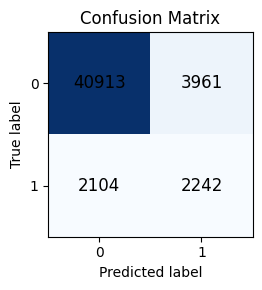

In [42]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)

In [44]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "ModelOHE3MV_preds.csv")